# Model Training v2 - With Feature Engineering

**Goal:** Train a model to predict `averageRating` using engineered features.

**Input:** `data/movies_wide.csv` (298k movies, 31 features)

**Comparison:** Mucahit's baseline (4 raw features, R² = 0.009) vs our v2 (31 engineered features)

**Sections:**
1. Load Data
2. Train/Test Split
3. Baseline Model (Linear Regression)
4. Model Comparison (Ridge, RandomForest, XGBoost)
5. Evaluation & Results
6. Export Best Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For saving model
import pickle

# Configuration
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")

## 1. Load Data

In [2]:
# Load the feature-engineered dataset
df = pd.read_csv("../data/movies_wide.csv")

print(f"Loaded {len(df):,} movies with {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")
display(df.head())

Loaded 298,616 movies with 32 columns

Columns: ['averageRating', 'isAdult', 'startYear', 'numVotes', 'genre_count', 'decade', 'movie_age', 'runtimeMinutes_capped', 'log_numVotes', 'hit', 'Genre_Drama', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Romance', 'Genre_Action', 'Genre_Crime', 'Genre_Thriller', 'Genre_Horror', 'Genre_Adventure', 'Genre_Mystery', 'Genre_Family', 'Genre_Biography', 'Genre_Fantasy', 'Genre_History', 'Genre_Music', 'Genre_Sci-Fi', 'Genre_Musical', 'Genre_War', 'Genre_Animation', 'Genre_Western', 'Genre_Sport', 'Genre_Adult']


,averageRating,isAdult,startYear,numVotes,genre_count,decade,movie_age,runtimeMinutes_capped,log_numVotes,hit,Genre_Drama,Genre_Comedy,Genre_Documentary,Genre_Romance,Genre_Action,Genre_Crime,Genre_Thriller,Genre_Horror,Genre_Adventure,Genre_Mystery,Genre_Family,Genre_Biography,Genre_Fantasy,Genre_History,Genre_Music,Genre_Sci-Fi,Genre_Musical,Genre_War,Genre_Animation,Genre_Western,Genre_Sport,Genre_Adult
0,5.2,0,1894.0,232,1,1890.0,132.0,45,5.451038,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.3,0,1897.0,584,3,1890.0,129.0,100,6.371612,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5.4,0,1900.0,67,2,1900.0,126.0,40,4.219508,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,6.0,0,1906.0,1046,3,1900.0,120.0,70,6.953684,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4.8,0,1907.0,37,1,1900.0,119.0,90,3.637586,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# Check for missing values
print("--- Missing Values ---")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

--- Missing Values ---
startYear    22
decade       22
movie_age    22
dtype: int64


In [4]:
# Drop rows with missing values (22 movies missing startYear)
df = df.dropna(subset=['startYear'])
print(f"Dropped rows with missing values. Remaining: {len(df):,} movies")

Dropped rows with missing values. Remaining: 298,594 movies


## 2. Train/Test Split

In [5]:
# Define target and features
TARGET = "averageRating"

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train/Test split (70/30 like Mucahit's baseline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42  # random_state for reproducibility
)

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nFeatures: {X.columns.tolist()}")

Training set: 209,015 samples, 31 features
Test set: 89,579 samples

Features: ['isAdult', 'startYear', 'numVotes', 'genre_count', 'decade', 'movie_age', 'runtimeMinutes_capped', 'log_numVotes', 'hit', 'Genre_Drama', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Romance', 'Genre_Action', 'Genre_Crime', 'Genre_Thriller', 'Genre_Horror', 'Genre_Adventure', 'Genre_Mystery', 'Genre_Family', 'Genre_Biography', 'Genre_Fantasy', 'Genre_History', 'Genre_Music', 'Genre_Sci-Fi', 'Genre_Musical', 'Genre_War', 'Genre_Animation', 'Genre_Western', 'Genre_Sport', 'Genre_Adult']


## 3. Baseline Model (Linear Regression)

First, let's replicate Mucahit's approach but with our engineered features.

In [6]:
# Preprocessing: Impute missing values + Scale features
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
    ],
    remainder="drop"
)

# Baseline: Linear Regression (like Mucahit)
baseline_model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

print(f"Features used: {len(numeric_features)}")
print(numeric_features)

Features used: 31
['isAdult', 'startYear', 'numVotes', 'genre_count', 'decade', 'movie_age', 'runtimeMinutes_capped', 'log_numVotes', 'hit', 'Genre_Drama', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Romance', 'Genre_Action', 'Genre_Crime', 'Genre_Thriller', 'Genre_Horror', 'Genre_Adventure', 'Genre_Mystery', 'Genre_Family', 'Genre_Biography', 'Genre_Fantasy', 'Genre_History', 'Genre_Music', 'Genre_Sci-Fi', 'Genre_Musical', 'Genre_War', 'Genre_Animation', 'Genre_Western', 'Genre_Sport', 'Genre_Adult']


In [7]:
# Train baseline model
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate
print("--- Baseline Model (Linear Regression) ---")
print(f"R² Score: {r2_score(y_test, y_pred_baseline):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_baseline)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_baseline):.4f}")
print(f"\nMucahit's baseline (4 raw features): R² = 0.0088")
print(f"Our baseline (31 engineered features): R² = {r2_score(y_test, y_pred_baseline):.4f}")

--- Baseline Model (Linear Regression) ---
R² Score: 0.2281
RMSE: 1.1863
MAE: 0.9099

Mucahit's baseline (4 raw features): R² = 0.0088
Our baseline (31 engineered features): R² = 0.2281


## 4. Model Comparison

Let's try different algorithms to see which works best.

In [8]:
# Define models to compare
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
}

# Store results
results = []

In [ ]:
# Train and evaluate each model
for name, regressor in models.items():
    print(f"Training {name}...")

    # Create pipeline
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("regressor", regressor)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "pipeline": pipeline  # Store for later
    })

    print(f"  R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}\n")

Training LinearRegression...
  R²: 0.2281, RMSE: 1.1863, MAE: 0.9099

Training Ridge...
  R²: 0.2281, RMSE: 1.1863, MAE: 0.9099

Training RandomForest...
  R²: 0.3121, RMSE: 1.1199, MAE: 0.8532



## 5. Evaluation & Results

In [10]:
# Results comparison table
results_df = pd.DataFrame(results).drop(columns=["pipeline"])

# Add Mucahit's baseline for reference
mucahit_baseline = pd.DataFrame([{
    "Model": "Mucahit Baseline (4 features)",
    "R²": 0.0088,
    "RMSE": None,
    "MAE": None
}])

comparison_df = pd.concat([mucahit_baseline, results_df], ignore_index=True)
print("--- Model Comparison ---")
display(comparison_df)

--- Model Comparison ---


/tmp/ipykernel_146948/4285584840.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([mucahit_baseline, results_df], ignore_index=True)


,Model,R²,RMSE,MAE
0,Mucahit Baseline (4 features),0.008800,NaN,NaN
1,LinearRegression,0.228052,1.186329,0.909904
2,Ridge,0.228052,1.186329,0.909904
3,RandomForest,0.312137,1.119855,0.853176


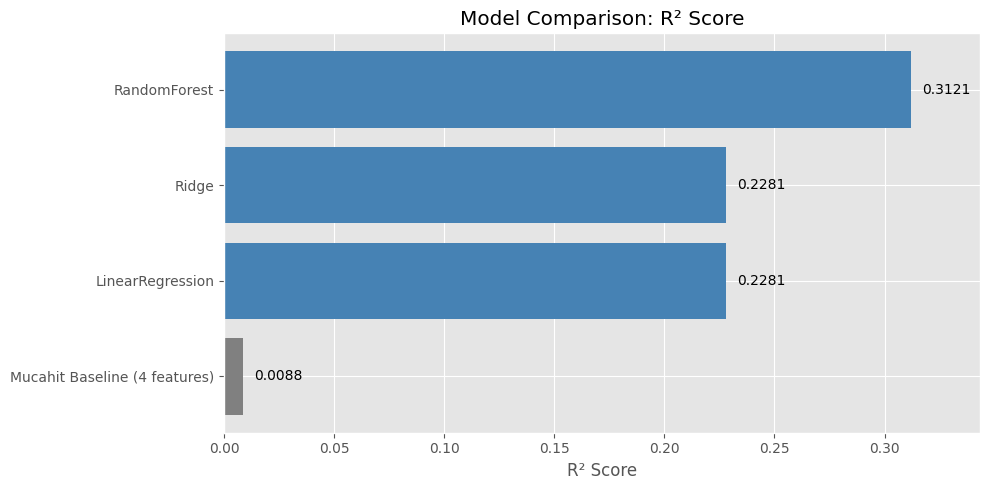

In [11]:
# Visualize R² scores
plt.figure(figsize=(10, 5))
colors = ['gray'] + ['steelblue'] * len(results)
plt.barh(comparison_df["Model"], comparison_df["R²"], color=colors)
plt.xlabel("R² Score")
plt.title("Model Comparison: R² Score")
plt.xlim(0, max(comparison_df["R²"].max() * 1.1, 0.1))

# Add value labels
for i, v in enumerate(comparison_df["R²"]):
    plt.text(v + 0.005, i, f"{v:.4f}", va="center")

plt.tight_layout()
plt.show()

In [12]:
# Find best model
best_result = max(results, key=lambda x: x["R²"])
best_model = best_result["pipeline"]

print(f"--- Best Model: {best_result['Model']} ---")
print(f"R²: {best_result['R²']:.4f}")
print(f"RMSE: {best_result['RMSE']:.4f}")
print(f"MAE: {best_result['MAE']:.4f}")

--- Best Model: RandomForest ---
R²: 0.3121
RMSE: 1.1199
MAE: 0.8532


### 5.1 Predicted vs Actual Analysis

Let's visualize how well the best model predicts ratings.

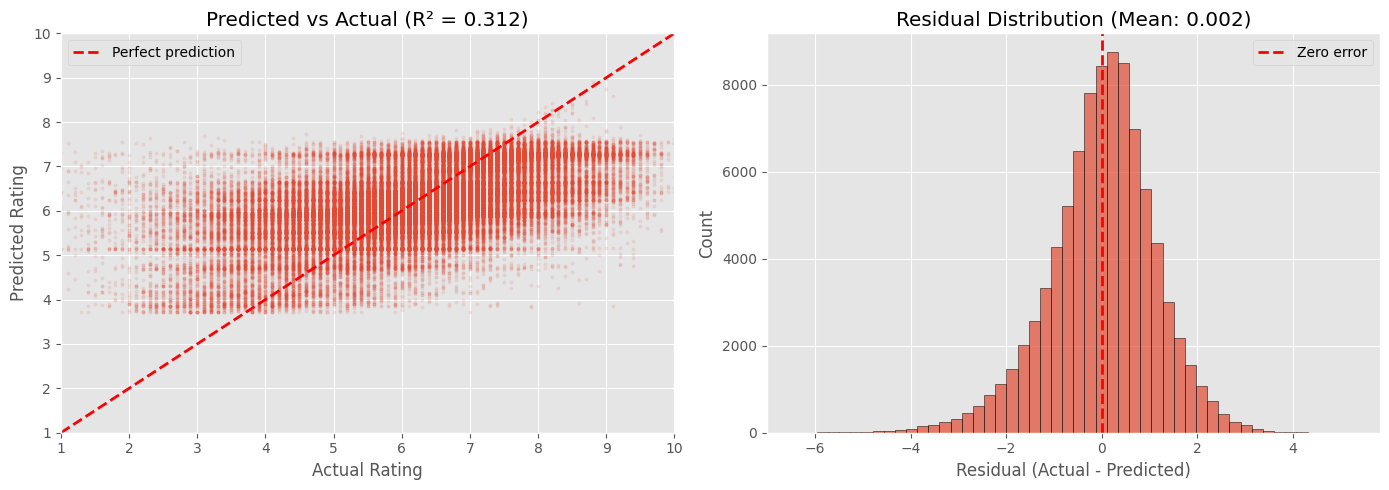

Residual stats: Mean=0.002, Std=1.120


In [13]:
# Get predictions from best model
y_pred_best = best_model.predict(X_test)

# Predicted vs Actual scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.1, s=5)
axes[0].plot([1, 10], [1, 10], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Predicted vs Actual (R² = {best_result["R²"]:.3f})')
axes[0].legend()
axes[0].set_xlim(1, 10)
axes[0].set_ylim(1, 10)

# Residual distribution
residuals = y_test - y_pred_best
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Residual Distribution (Mean: {residuals.mean():.3f})')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Residual stats: Mean={residuals.mean():.3f}, Std={residuals.std():.3f}")

In [14]:
# Sample predictions table - show 15 random examples
sample_idx = np.random.seed(42)
sample_indices = np.random.choice(len(y_test), 15, replace=False)

sample_df = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices].values,
    'Predicted': y_pred_best[sample_indices],
    'Error': y_test.iloc[sample_indices].values - y_pred_best[sample_indices]
})
sample_df['Abs Error'] = sample_df['Error'].abs()
sample_df = sample_df.round(2)

print("--- Sample Predictions (15 random movies) ---")
display(sample_df)

print(f"\nAverage absolute error in sample: {sample_df['Abs Error'].mean():.2f} rating points")

--- Sample Predictions (15 random movies) ---


,Actual,Predicted,Error,Abs Error
0,4.7,4.61,0.09,0.09
1,4.7,7.29,-2.59,2.59
2,5.3,4.72,0.58,0.58
3,6.8,7.05,-0.25,0.25
4,6.1,6.01,0.09,0.09
5,5.4,5.41,-0.01,0.01
6,6.7,6.90,-0.20,0.20
7,7.0,7.10,-0.10,0.10
8,6.4,6.03,0.37,0.37
9,7.8,6.33,1.47,1.47



Average absolute error in sample: 0.85 rating points


**Interpretation:**

- **Scatter plot**: Points close to the red diagonal = good predictions. The spread shows prediction uncertainty.
- **Residuals**: Centered around 0 = no systematic bias. The model isn't consistently over/under-predicting.
- **Sample table**: Real examples showing prediction accuracy on individual movies.

## 6. Export Best Model

In [15]:
# Export best model as pickle
model_path = "../models/model_v2.pkl"

# Create models directory if it doesn't exist
import os
os.makedirs("../models", exist_ok=True)

with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"Model exported to: {model_path}")

# Verify it loads correctly
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

# Quick sanity check
test_pred = loaded_model.predict(X_test[:5])
print(f"\nSanity check - predictions on 5 samples: {test_pred}")

Model exported to: ../models/model_v2.pkl

Sanity check - predictions on 5 samples: [7.37470108 7.20250987 4.70489807 6.73515512 7.26038558]


## Summary

**Key Improvements over Mucahit's Baseline:**
- Feature engineering: 4 raw features → 31 engineered features
- Genre one-hot encoding: captures content type signal
- Log-transformed votes: normalized skewed popularity data
- `hit` feature: binary flag for top 20% popular movies
- Temporal features: `movie_age`, `decade`

**Next Steps:**
- Hyperparameter tuning (GridSearchCV)
- Try XGBoost/LightGBM
- Feature importance analysis
- Integrate with API

## BENS STUFF FOR R2 OPTIMIZATION STARTS FROM BELOW HERE, UPPER PART CLONED FROM model_training_v2.ipynb ##

In [18]:
# Lets try log-transforming the targets

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [24]:
# requires pip install catboost

from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    loss_function="RMSE",
    random_seed=1,
    verbose=200
)

In [25]:
# define the new pipeline

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", cat_model)
])

In [26]:
# train the new pipeline

pipeline.fit(X_train, y_train_log)

# runtime on my machine: 6.3s

0:	learn: 0.2063554	total: 12.2ms	remaining: 12.2s
200:	learn: 0.1724094	total: 1.25s	remaining: 4.95s
400:	learn: 0.1706262	total: 2.23s	remaining: 3.33s
600:	learn: 0.1695144	total: 3.22s	remaining: 2.14s
800:	learn: 0.1686778	total: 4.22s	remaining: 1.05s
999:	learn: 0.1680529	total: 5.2s	remaining: 0us


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
# make a prediction and remove log transformation

y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [ ]:
# check resulting r2

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

# Minor improvement, R² now 0.3315

R²: 0.3315


In [ ]:
# Catboost results in some improvement, but still not great. Let's try HistGradientBoostingRegressor instead, superior for dense numerical feature sets:

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import numpy as np

numeric_features = X_train.columns

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numeric_features)
])

model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.03,
    max_iter=1500,
    min_samples_leaf=30,
    l2_regularization=0.1,
    random_state=1
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", model)
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print(f"R²: {r2_score(y_test, pred):.4f}")

# runtime on my machine: 6.7s

# Minor additional boost in R², now 0.3369


R²: 0.3369


In [ ]:
# Our feature set seems redundant, less is more? Let's try dropping some features and re-evaluate..


# "decade",          # redundant to startYear
# "movie_age",       # redundant to startYear
# "log_numVotes",    # redundant to numVotes
# "genre_count",     # redundant to Genre_* Dummies


import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# 1) Drop redundant columns
drop_cols = ["decade", "movie_age", "log_numVotes", "genre_count"]

X_train_red = X_train.drop(columns=drop_cols)
X_test_red  = X_test.drop(columns=drop_cols)

# 2) Rebuild preprocessor to match the reduced column set
numeric_features_red = X_train_red.columns.tolist()

preprocessor_red = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features_red),
    ],
    remainder="drop"
)

# 3) Model (tweak params if you want)
model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.03,
    max_iter=1500,
    min_samples_leaf=30,
    l2_regularization=0.1,
    random_state=1
)

# 4) Pipeline
pipe_red = Pipeline([
    ("preprocess", preprocessor_red),
    ("model", model)
])

# 5) Log-transform target (train on log scale)
y_train_log = np.log1p(y_train)

pipe_red.fit(X_train_red, y_train_log)

# 6) Predict and invert transform back to original scale
pred_log = pipe_red.predict(X_test_red)
pred = np.expm1(pred_log)

# 7) Evaluate
print(f"R²: {r2_score(y_test, pred):.4f}")

# Runtime on my machine: 5.9s
# Resulting R²: 0.3280

R²: 0.3280


In [ ]:
# Maybe I dropped features too aggressively? Lets play around a bit and try again
# Partial feature drop (keep strong signals), train HGBR with log-target, evaluate with 4 decimals

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# 1) Drop only the truly redundant time features
drop_cols = ["decade", "movie_age"]  # keep log_numVotes and genre_count

X_train_red = X_train.drop(columns=drop_cols)
X_test_red  = X_test.drop(columns=drop_cols)

# 2) Rebuild preprocessor to match the reduced column set
numeric_features_red = X_train_red.columns.tolist()

preprocessor_red = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features_red),
    ],
    remainder="drop"
)

# 3) Stronger HGBR setup (more capacity to avoid underfitting)
model = HistGradientBoostingRegressor(
    max_depth=10,
    learning_rate=0.03,
    max_iter=2500,
    min_samples_leaf=15,
    l2_regularization=0.0,
    max_bins=255,
    random_state=1
)

# 4) Pipeline
pipe_red = Pipeline([
    ("preprocess", preprocessor_red),
    ("model", model)
])

# 5) Log-transform target (train on log scale)
y_train_log = np.log1p(y_train)

pipe_red.fit(X_train_red, y_train_log)

# 6) Predict and invert transform back to original scale
pred_log = pipe_red.predict(X_test_red)
pred = np.expm1(pred_log)

# 7) Evaluate
print(f"R²: {r2_score(y_test, pred):.4f}")

# Runtime on my machine: 4.3s.
# Resulting R²: 0.3266.

# Not an improvement

R²: 0.3266


In [36]:
# Log transform did not really do much, Lets try HGBR (best performer so far) again without log-target (since log-target regressed), evaluate with 4 decimals

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# Use ALL your numeric columns (dataset is already numeric: dummies + engineered features)
numeric_features = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
    ],
    remainder="drop"
)

model = HistGradientBoostingRegressor(
    max_depth=6,            # start moderate
    learning_rate=0.05,     # slightly higher
    max_iter=1200,
    min_samples_leaf=20,
    l2_regularization=0.1,
    max_bins=255,
    random_state=1
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", model)
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print(f"R²: {r2_score(y_test, pred):.4f}")

R²: 0.3365


In [ ]:
# Can we try an ensemble approach utilizing multiple models?

# Mini ensemble: HGBR + Ridge

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

numeric_features = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[("num", SimpleImputer(strategy="median"), numeric_features)],
    remainder="drop"
)

# Model 1: HGBR
hgbr = Pipeline([
    ("preprocess", preprocessor),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=1200,
        min_samples_leaf=20,
        l2_regularization=0.1,
        random_state=1
    ))
])

# Model 2: Ridge
ridge = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=1.0))
])

# Train both
hgbr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Predict
pred_hgbr = hgbr.predict(X_test)
pred_ridge = ridge.predict(X_test)

# Weighted average
pred_ens = 0.7 * pred_hgbr + 0.3 * pred_ridge

print(f"R² Ensemble: {r2_score(y_test, pred_ens):.4f}")

# Runtime on my machine: 5.6s
# Resulting R²: 0.3265

# Not an improvement

R² Ensemble: 0.3265


## I think we have pushed the limit of classical regression. Let's try using the features I extracted with the tfidf pipeline (see notebook_ben) ##

In [1]:
# Import the tfidf enriched dataframe created in notebook_ben

import pandas as pd
wide_df_enriched = pd.read_parquet("wide_df_features.parquet", engine="fastparquet")

In [2]:
wide_df_enriched.head(5)

,id,imdbId,title,original_title,overview,genre_names,keyword_names,cast_top,directors,original_language,year,runtime,vote_average,vote_count,popularity,embedding_text,overview_clean,plot_main_points,dominant_topic,topic_confidence
0,862,tt0114709,Toy Story,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],en,1995.0,81.0,7.7,5415.0,21.946943,"Title: Toy Story\nOverview: Led by Woody, Andy...","led by woody, andy's toys live happily in his ...","[woody, andy, toys, aside, afraid, differences...",9,0.815731
1,8844,tt0113497,Jumanji,Jumanji,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston],en,1995.0,104.0,6.9,2413.0,17.015539,Title: Jumanji\nOverview: When siblings Judy a...,when siblings judy and peter discover an encha...,"[game, alan, risky, trapped inside, 26, judy, ...",12,0.613343
2,15602,tt0113228,Grumpier Old Men,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch],en,1995.0,101.0,6.5,92.0,11.712900,Title: Grumpier Old Men\nOverview: A family we...,a family wedding reignites the ancient feud be...,"[max, worry, scare, cooking, feud, buddies, fi...",9,0.840365
3,31357,tt0114885,Waiting to Exhale,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin...","[Whitney Houston, Angela Bassett, Loretta Devi...",[Forest Whitaker],en,1995.0,127.0,6.1,34.0,3.859495,Title: Waiting to Exhale\nOverview: Cheated on...,"cheated on, mistreated and stepped on, the wom...","[bernie, string, elusive, holding, robin, wait...",9,0.809977
4,11862,tt0113041,Father of the Bride Part II,Father of the Bride Part II,Just when George Banks has recovered from his ...,[Comedy],"[baby, midlife crisis, confidence, aging, daug...","[Steve Martin, Diane Keaton, Martin Short, Kim...",[Charles Shyer],en,1995.0,106.0,5.7,173.0,8.387519,Title: Father of the Bride Part II\nOverview: ...,just when george banks has recovered from his ...,"[george, banks, nina, expecting, planning, sel...",9,0.812845


In [49]:
# Define target and features, perform train/test split on the new dataframe generated by using the tfidf pipeline

TARGET = "vote_average"

X = wide_df_enriched.drop(columns=[TARGET])
y = wide_df_enriched[TARGET]

# Train/Test split (70/30 like Mucahit's baseline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42  # random_state for reproducibility
)

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nFeatures: {X.columns.tolist()}")

Training set: 32,837 samples, 19 features
Test set: 14,074 samples

Features: ['id', 'imdbId', 'title', 'original_title', 'overview', 'genre_names', 'keyword_names', 'cast_top', 'directors', 'original_language', 'year', 'runtime', 'vote_count', 'popularity', 'embedding_text', 'overview_clean', 'plot_main_points', 'dominant_topic', 'topic_confidence']


In [ ]:
# Maybe the text tower approach can add some value?

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

TARGET = "vote_average"
TEXT_COL = "embedding_text"

# 1) Drop rows with NaN target in train/test (keep alignment!)
train_mask = y_train.notna()
test_mask  = y_test.notna()

X_train_clean = X_train.loc[train_mask].copy()
y_train_clean = y_train.loc[train_mask].copy()

X_test_clean  = X_test.loc[test_mask].copy()
y_test_clean  = y_test.loc[test_mask].copy()

# 2) Extract text and fill missing text
X_train_text = X_train_clean[TEXT_COL].fillna("")
X_test_text  = X_test_clean[TEXT_COL].fillna("")

# 3) Text tower
text_tower = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50000,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9,
        strip_accents="unicode",
        lowercase=True
    )),
    ("ridge", Ridge())
])

# 4) Tune alpha
param_grid = {"ridge__alpha": [0.1, 0.3, 1.0, 2.0, 5.0, 10.0, 30.0]}

search = GridSearchCV(
    text_tower,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_text, y_train_clean)

pred_text = search.predict(X_test_text)

print(f"Best alpha: {search.best_params_['ridge__alpha']}")
print(f"Text Tower R²: {r2_score(y_test_clean, pred_text):.4f}")
print(f"Dropped train rows (NaN y): {(~train_mask).sum():,}")
print(f"Dropped test rows (NaN y): {(~test_mask).sum():,}")

# run time on my machine: 36.8s

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best alpha: 5.0
Text Tower R²: 0.1269
Dropped train rows (NaN y): 2
Dropped test rows (NaN y): 2


## -> we now know that our extracted features barely correlate with the rating. Let's move on and try a new approach ##

In [3]:
# Frequency features for list-like columns (train-only stats to avoid leakage)
# Works with wide_df_enriched where list columns are stored as actual lists OR stringified lists.

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

TARGET = "vote_average"

# 1) Split (same as your baseline)
X = wide_df_enriched.drop(columns=[TARGET])
y = wide_df_enriched[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# 2) Drop NaN targets (keep alignment)
train_mask = y_train.notna()
test_mask  = y_test.notna()

X_train_clean = X_train.loc[train_mask].copy()
y_train_clean = y_train.loc[train_mask].copy()

X_test_clean  = X_test.loc[test_mask].copy()
y_test_clean  = y_test.loc[test_mask].copy()

# 3) Helpers: parse list-like fields
def to_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1]
    # split on commas (good enough for your simple tokens/names)
    parts = [p.strip().strip("'").strip('"') for p in s.split(",") if p.strip()]
    return parts

def build_freq_map(series):
    freq = {}
    for x in series:
        for item in to_list(x):
            freq[item] = freq.get(item, 0) + 1
    return freq

def add_freq_features(df, col, freq_map, topk=5):
    items = df[col].apply(to_list)

    # how many items in the list
    df[f"{col}__n"] = items.apply(len)

    # sum of top-k frequencies (how "mainstream" the list is)
    df[f"{col}__freq_sum_top{topk}"] = items.apply(
        lambda xs: sum(sorted([freq_map.get(i, 0) for i in xs], reverse=True)[:topk])
    )

    # max frequency among items (presence of a very common name/keyword)
    df[f"{col}__freq_max"] = items.apply(
        lambda xs: max([freq_map.get(i, 0) for i in xs], default=0)
    )

    return df

# 4) Choose list-like columns present in your df
list_cols = ["genre_names", "keyword_names", "cast_top", "directors"]
list_cols = [c for c in list_cols if c in X_train_clean.columns]

# 5) Build frequency maps on TRAIN only
freq_maps = {col: build_freq_map(X_train_clean[col]) for col in list_cols}

# 6) Add features to train/test
for col in list_cols:
    X_train_clean = add_freq_features(X_train_clean, col, freq_maps[col], topk=5)
    X_test_clean  = add_freq_features(X_test_clean,  col, freq_maps[col], topk=5)

# 7) Quick sanity output
added = [c for c in X_train_clean.columns if "__freq_" in c or c.endswith("__n")]
print(f"Added {len(added)} frequency features:")
print(added)

print(f"Dropped train rows (NaN y): {(~train_mask).sum():,}")
print(f"Dropped test rows (NaN y): {(~test_mask).sum():,}")

# X_train_clean / X_test_clean now contain extra numeric features you can feed into HGBR/ExtraTrees.


Added 12 frequency features:
['genre_names__n', 'genre_names__freq_sum_top5', 'genre_names__freq_max', 'keyword_names__n', 'keyword_names__freq_sum_top5', 'keyword_names__freq_max', 'cast_top__n', 'cast_top__freq_sum_top5', 'cast_top__freq_max', 'directors__n', 'directors__freq_sum_top5', 'directors__freq_max']
Dropped train rows (NaN y): 2
Dropped test rows (NaN y): 2


In [ ]:
# Let's make sure the target feature did not somehow leak into the dataframe
X_train_clean.head(5)

,id,imdbId,title,original_title,overview,genre_names,keyword_names,cast_top,directors,original_language,...,genre_names__freq_max,keyword_names__n,keyword_names__freq_sum_top5,keyword_names__freq_max,cast_top__n,cast_top__freq_sum_top5,cast_top__freq_max,directors__n,directors__freq_sum_top5,directors__freq_max
26210,260346,tt2446042,Taken 3,Taken 3,Ex-government operative Bryan Mills finds his ...,"[Thriller, Action]","[revenge, murder, on the run, fugitive, framed...","[Liam Neeson, Forest Whitaker, Maggie Grace, F...",[Olivier Megaton],en,...,5518,7,1535,931,10,156,51,1,6,6
27615,238206,tt3746820,Eddie Izzard: Force Majeure Live,Eddie Izzard: Force Majeure Live,Force Majeure (French) (pronounced: fors mah-Z...,[Comedy],[],[Eddie Izzard],[],en,...,9424,0,0,0,1,25,25,0,0,0
14183,17654,tt1136608,District 9,District 9,"Aliens land in South Africa and, with their sh...",[Science Fiction],"[slum, street gang, mutation, south africa, jo...","[Sharlto Copley, Jason Cope, Nathalie Boltt, S...",[Neill Blomkamp],en,...,2201,20,566,190,10,28,8,1,6,6
12073,19968,tt0052005,No Time For Sergeants,No Time For Sergeants,Georgia farm boy Will Stockdale is about to bu...,"[Comedy, Drama]",[army],"[Andy Griffith, Nick Adams, Myron McCormick, M...",[Mervyn LeRoy],en,...,14747,1,84,84,10,60,21,1,26,26
30925,217576,tt2406422,Walking the Camino: Six Ways to Santiago,Walking the Camino: Six Ways to Santiago,'A Walk to Within: The Camino de Santiago' tel...,[Documentary],[woman director],[],[Lydia B. Smith],en,...,2793,1,2203,2203,0,0,0,1,1,1


In [ ]:
# Let's compare HGBR and ExtraTrees algorithms using the transformed freq-features

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor

# 1) Drop identifiers + long text + raw list columns (freq-features are already added)
DROP_COLS = [
    "id", "imdbId",
    "title", "original_title",
    "overview", "embedding_text", "overview_clean", "plot_main_points",
    "genre_names", "keyword_names", "cast_top", "directors"
]
DROP_COLS = [c for c in DROP_COLS if c in X_train_clean.columns]

Xtr = X_train_clean.drop(columns=DROP_COLS, errors="ignore").copy()
Xte = X_test_clean.drop(columns=DROP_COLS, errors="ignore").copy()

# 2) Detect numeric/categorical columns
cat_cols = Xtr.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = Xtr.select_dtypes(include=["int64", "float64", "int32", "float32", "bool"]).columns.tolist()

# 3) Dense one-hot encoder (HGBR needs dense)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # older sklearn fallback
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor_dense = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", ohe),
        ]), cat_cols),
    ],
    remainder="drop"
)

# --------------------
# Model A: HGBR (dense input)
# --------------------
hgbr = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.05,
    max_iter=2000,
    min_samples_leaf=20,
    l2_regularization=0.1,
    max_bins=255,
    random_state=1
)

pipe_hgbr = Pipeline([
    ("preprocess", preprocessor_dense),
    ("model", hgbr)
])

pipe_hgbr.fit(Xtr, y_train_clean)
pred_hgbr = pipe_hgbr.predict(Xte)
print(f"HGBR R²: {r2_score(y_test_clean, pred_hgbr):.4f}")

# --------------------
# Model B: ExtraTrees (can handle dense too; keep same preprocessor for consistency)
# --------------------
et = ExtraTreesRegressor(
    n_estimators=2000,
    max_depth=None,
    min_samples_leaf=10,
    max_features=0.5,
    n_jobs=-1,
    random_state=1
)

pipe_et = Pipeline([
    ("preprocess", preprocessor_dense),
    ("model", et)
])

pipe_et.fit(Xtr, y_train_clean)
pred_et = pipe_et.predict(Xte)
print(f"ExtraTrees R²: {r2_score(y_test_clean, pred_et):.4f}")

# --------------------
# Simple Ensemble
# --------------------
pred_ens = 0.55 * pred_hgbr + 0.45 * pred_et
print(f"Ensemble R²: {r2_score(y_test_clean, pred_ens):.4f}")


# run time on my machine: 9.7s

# HGBR R²: 0.6982
# ExtraTrees R²: 0.5152
# Ensemble R²: 0.6620


HGBR R²: 0.6976
ExtraTrees R²: 0.5162
Ensemble R²: 0.6622


In [ ]:
## R² = 0.6982 seems too good to be true, lets perform some sanity checks:

In [ ]:
# Did the target leak somehow?

TARGET = "vote_average"

# should be False
print("TARGET in X_train_clean?", TARGET in X_train_clean.columns)
print("TARGET in Xtr?", TARGET in Xtr.columns)
print("TARGET in X_test_clean?", TARGET in X_test_clean.columns)
print("TARGET in Xte?", TARGET in Xte.columns)

TARGET in X_train_clean? False
TARGET in Xtr? False
TARGET in X_test_clean? False
TARGET in Xte? False


In [ ]:
# Check for related columns present in the data set

suspects = [c for c in Xtr.columns if "vote" in c.lower() or "rating" in c.lower() or "average" in c.lower()]
print("Suspicious columns:", suspects)

# apparently correlated but seems reasonable to me -> good movies are watched by many people and get more votes

Suspicious columns: ['vote_count']


In [7]:
from sklearn.metrics import r2_score

pred_train = pipe_hgbr.predict(Xtr)
pred_test  = pipe_hgbr.predict(Xte)

print(f"Train R²: {r2_score(y_train_clean, pred_train):.4f}")
print(f"Test  R²: {r2_score(y_test_clean, pred_test):.4f}")

Train R²: 0.7482
Test  R²: 0.6976


In [8]:
import numpy as np
from sklearn.base import clone
from sklearn.metrics import r2_score

y_shuffled = y_train_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
Xtr_shuf = Xtr.reset_index(drop=True)

pipe_shuf = clone(pipe_hgbr)
pipe_shuf.fit(Xtr_shuf, y_shuffled)

pred_shuf = pipe_shuf.predict(Xte)
print(f"Shuffle test R² (should be ~0): {r2_score(y_test_clean, pred_shuf):.4f}")

Shuffle test R² (should be ~0): 0.0005


In [9]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(pipe_hgbr, Xtr, y_train_clean, scoring="r2", cv=cv, n_jobs=-1)

print("CV R² scores:", np.round(scores, 4))
print(f"CV mean ± std: {scores.mean():.4f} ± {scores.std():.4f}")


CV R² scores: [0.7048 0.6915 0.7033 0.6942 0.6982]
CV mean ± std: 0.6984 ± 0.0051


In [13]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score

def make_hgbr_pipeline_for_X(X: pd.DataFrame, random_state=1):
    # detect types dynamically from the given X
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32", "bool"]).columns.tolist()

    # dense one-hot encoder (HGBR needs dense)
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", ohe),
            ]), cat_cols),
        ],
        remainder="drop"
    )

    model = HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.05,
        max_iter=2000,
        min_samples_leaf=20,
        l2_regularization=0.1,
        max_bins=255,
        random_state=random_state
    )

    return Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])


# Identify your engineered freq features
freq_cols = [c for c in Xtr.columns if "__freq_" in c or c.endswith("__n")]

Xtr_no_freq = Xtr.drop(columns=freq_cols, errors="ignore")
Xte_no_freq = Xte.drop(columns=freq_cols, errors="ignore")

pipe_no_freq = make_hgbr_pipeline_for_X(Xtr_no_freq, random_state=42)
pipe_no_freq.fit(Xtr_no_freq, y_train_clean)

pred_no_freq = pipe_no_freq.predict(Xte_no_freq)
print(f"R² without freq features: {r2_score(y_test_clean, pred_no_freq):.4f}")


R² without freq features: 0.6673


In [11]:
drop_exposure = [c for c in ["vote_count", "popularity"] if c in Xtr.columns]

Xtr_no_exp = Xtr.drop(columns=drop_exposure, errors="ignore")
Xte_no_exp = Xte.drop(columns=drop_exposure, errors="ignore")

pipe_no_exp = make_hgbr_pipeline_for_X(Xtr_no_exp, random_state=42)
pipe_no_exp.fit(Xtr_no_exp, y_train_clean)

pred_no_exp = pipe_no_exp.predict(Xte_no_exp)
print(f"R² without vote_count/popularity: {r2_score(y_test_clean, pred_no_exp):.4f}")


R² without vote_count/popularity: 0.1711


In [ ]:
Suspicious columns: ['vote_count']

Train R²: 0.7478
Test  R²: 0.6982

Shuffle test R² (should be ~0): 0.0005

CV R² scores: [0.6971 0.6839 0.6946 0.7107 0.7094]
CV mean ± std: 0.6992 ± 0.0100

R² without freq features: 0.6673

R² without vote_count/popularity: 0.1711